# PyTorch Workflow


what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "fitting the model to data(training)",
                      4: "making predictions and evaluting a model(inference)",
                      5: "putting it all together"}

In [ ]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks
import matplotlib.pyplot as plt

#Check PyTorch version
torch.__version__

'1.13.0+cu116'

## 1. Data (preparing and loading)
Data can be almost anything ... in machine learning

ML is a game of two parts:
1. get data into a numerical representation
2. build a model to learn patterns in that numerical representation

We will use a linear regression formula to make a straight line with known **parameters**.


In [ ]:
# Create *known* parameters
weight =0.7
bias =0.3

In [ ]:
# Create 
start =0
end=1
step =0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X +bias

In [ ]:
X[:10],y[:10],len(X),len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]), 50, 50)

### Split data into training and test sets



In [ ]:
# Create a train/test split
train_split = int(0.8* len(X))
X_train,y_train = X[:train_split],y[:train_split]
X_test,y_test = X[train_split:], y[train_split:]

len(X_train),len(y_train)

(40, 40)

In [ ]:
# Build a function to visualize the data
def plot_predictions(train_data =X_train, train_labels=y_train, test_data =X_test, test_labels =y_test, predictions=None):
  """
  Plot training data,test data and compare predictions
  """
  plt.figure(figsize = (10,7))

  #Plot training data in blud
  plt.scatter(train_data,train_labels,c='b',s=4,label ='Training data')
  
  #Plot test data in green
  plt.scatter(test_data,test_labels,c='g',s=4,label = "Testing data")

  # Are there predictions?
  if predictions is not None:
    #Plot the predictions if they exist
    plt.scatter(test_data,predictions, c='r',s=4, label="predictions")

  #Show the legend
    plt.legend(prop = {"size":14})

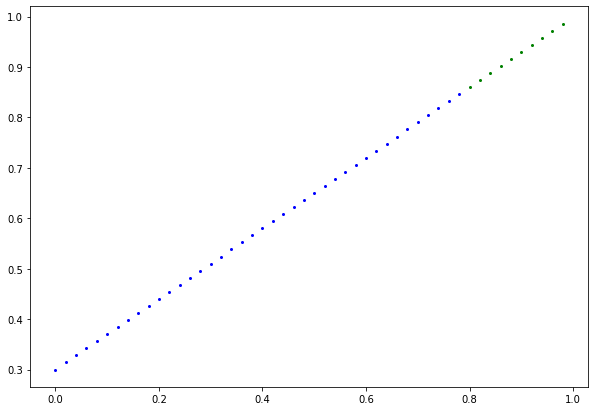

In [ ]:
plot_predictions()

## 2. Build model
our first PyTorch model!
we are going to be building classes throughout the course, I'd recommend getting farmiliar with OOP with Python in following resources from Real Python.

What our model does:
* Start with random values(weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the idea values ( the weight & bias values we used to create the data)

How does it do so?

Through two main algorithms:
1. Gradient descent
2. Backpropagation

In [ ]:
from torch import nn
# Create a linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherihits from nn.Module
  def __init__(self):
    super().__init__()
    self.weight=nn.Parameter(torch.rand(1,
                                         requires_grad=True,
                                         dtype=torch.float))
    self.bias = nn.Parameter(torch.rand(1,
                                        requires_grad = True,
                                        dtype = torch.float))
  #Forward method to define the computation in the model
  def forward(self,x:torch.Tensor)-> torch.Tensor: #<---"x" is the input data
    return self.weight*x + self.bias # this is the linear regression formula



### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs( a neural network can be considered as computaitonal graph)
* torch.nn.Parameter - shows our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.cc.Model - -The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient descent
* def forward() -  ALl nn.Model subclass require you to overwrite forward(), this method defines what happens in the forward computation.

### Checking out the internals of our model.

Now we've created the model but whatis inside...

So we can check our model parameter or what's inside our model using .parameters().

In [ ]:
from torch.random import manual_seed
# Create a random seed
torch,manual_seed(66)

#Create an instance of the model (this is a subclass of nn.Model)
model_0 = LinearRegressionModel()
# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.4976], requires_grad=True), Parameter containing:
 tensor([0.0230], requires_grad=True)]

In [ ]:
# List named parameters

model_0.state_dict()

OrderedDict([('weight', tensor([0.4976])), ('bias', tensor([0.0230]))])

### Making prediction using  'torch.inference_mode()'

To check our model's predictive power, let's see how well it predicts 'y_test" based on  'X-test'

When we pass data through our model, it's going to run it through the forward() method


In [ ]:
y_preds = model_0(X_test)
y_preds

tensor([[0.4211],
        [0.4310],
        [0.4410],
        [0.4510],
        [0.4609],
        [0.4709],
        [0.4808],
        [0.4908],
        [0.5007],
        [0.5107]], grad_fn=<AddBackward0>)

In [ ]:
# Make prediction with model
with torch.inference_mode():
  y_preds = model_0(X_test)
# You can also do something similar with torch.no_grad(), how ever torch.inference_mode() is preferred
with torch.no_grad():
  y_preds = model_0(X_test)

y_preds

tensor([[0.4211],
        [0.4310],
        [0.4410],
        [0.4510],
        [0.4609],
        [0.4709],
        [0.4808],
        [0.4908],
        [0.5007],
        [0.5107]])

In [ ]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

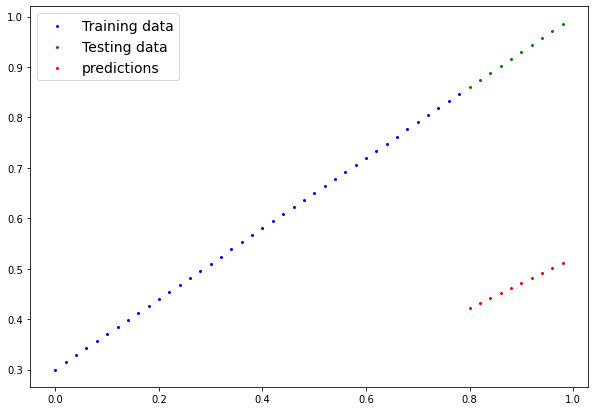

In [ ]:
plot_predictions(predictions = y_preds)

## 3.Training the model

The whole of idea of training is for a model to move from some **unknown** parameters (there may be random) for some known parameters Or in other words from a poor representation of the data to a better representation of the data

One way to measure how poor or how wrong your models predictions are is to use loss function.

* note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

**Loss function** : A function to measure how wrong your model prediction are to the ideal output, lower is better.

**Optimizer:** Take into account the loss of a model and adjust the model's parameters (e.g. weight & bias in our case) to improve the loss function

And specifically for PyTorch, we need:
* A training loop
* A testing loop


In [ ]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.4976])), ('bias', tensor([0.0230]))])

Q: Which loss function and optimizer should I use?

A: for a regression problem, a loss function of nn.L1Loss() and an optimizer like torch.optim.SGD() wil suffice.
For a classification problem, you would like to use a loss function of nn.BCELoss() (binary cross entropy loss).

In [ ]:
# Setup a loss function
loss_fn = nn.L1Loss()

#Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params= model_0.parameters(),
                             lr=0.01) #lr = learning rate = possibly the most important hyperparameter you can set

## Building a training loop (and a testing loop) in PyTorch.
A couple of things we need in a training loop:
0. Loop through the data
1. foward pass (this involves data moving through our model's forward() function) to make prediction on data. -  also called forward propagation
2. calculate the loss (compare forward pass predictions to ground truth labels)
3.  Optimizer zero grad
4.  Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**back propagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**grandient descent**)

In [ ]:
# Annepoch is one loop through the data
epochs = 100
epoch_count = []
loss_value = []
test_loss_value = []
### Training
# 0.Loop through the data
for epoch in range(epochs):
  # Set the model yo training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradient
  
  # 1. Forward pass
  y_pred = model_0(X_train)

  #2. Calculate the loss
  loss = loss_fn(y_pred,y_train)

  #3. Optimizer zero grad
  optimizer.zero_grad()

  #4. perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  #5. step the optimizer (perform Gradient Descent)
  optimizer.step() #by default how the optimizer changed will accumulate through the loop so we have to zero them above in step 3 for the next iteration of the loop

  #Testing
  model_0.eval()  # turns off different setting in the model not needed for evaluation/testing (Drop out norm layers)

  with torch.inference_mode(): #turns off gradient tracking & a couple more things behind
    #1. Do forward pass
    test_pred = model_0(X_test)
    #2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)
  #Print out what's happen
  if epoch % 10 ==0:
    epoch_count.append(epoch)
    loss_value.append(loss)
    test_loss_value.append(test_loss)
    print(f"Epoch:{epoch} | Loss: {loss} | Test_loss:{test_loss}")

Epoch:0 | Loss: 0.35592931509017944 | Test_loss:0.44364792108535767
Epoch:10 | Loss: 0.24071936309337616 | Test_loss:0.30893799662590027
Epoch:20 | Loss: 0.1255093514919281 | Test_loss:0.1742280274629593
Epoch:30 | Loss: 0.02035144902765751 | Test_loss:0.05020340159535408
Epoch:40 | Loss: 0.012691833078861237 | Test_loss:0.02860241010785103
Epoch:50 | Loss: 0.00926218368113041 | Test_loss:0.021016757935285568
Epoch:60 | Loss: 0.005827019456773996 | Test_loss:0.012744218111038208
Epoch:70 | Loss: 0.002388693392276764 | Test_loss:0.005158555693924427
Epoch:80 | Loss: 0.004423562437295914 | Test_loss:0.011067062616348267
Epoch:90 | Loss: 0.004423562437295914 | Test_loss:0.011067062616348267


In [ ]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6960])), ('bias', tensor([0.3060]))])

In [ ]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6960])), ('bias', tensor([0.3060]))])

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

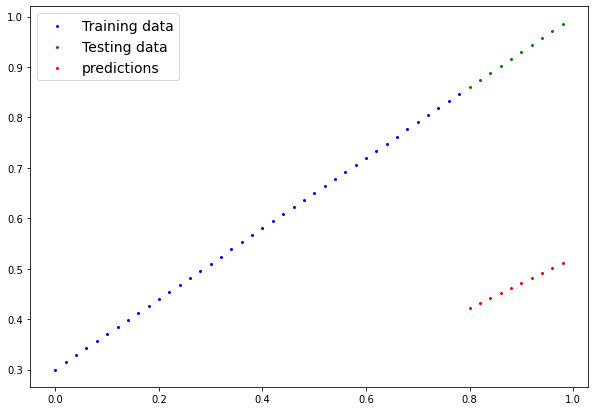

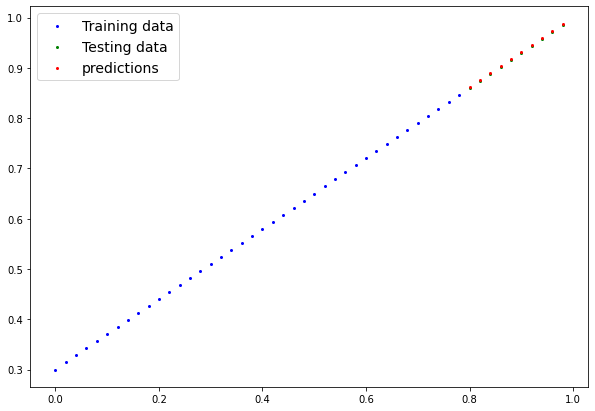

In [ ]:
plot_predictions(predictions=y_preds)
plot_predictions(predictions=y_preds_new)

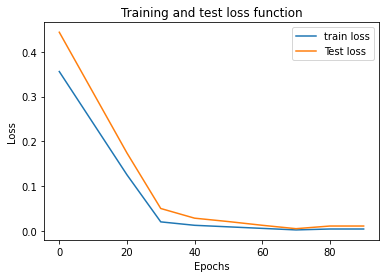

In [ ]:
import numpy as np
#Plot the loss curves
plt.plot(epoch_count,np.array(torch.tensor(loss_value).cpu().numpy()),label="train loss")
plt.plot(epoch_count,test_loss_value,label="Test loss")
plt.title("Training and test loss function")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

# Saving a model in PyTorch

There are three methods you should know:

1. 'torch.save()' - allows you save a PyTorch object in Python's pickle format
2. 'torch.load()' - allows you load a saved PyTorch object
3. 'torch.nn.Module.load_state_dic()' - this allows to load a model's saved sate dictionary

In [ ]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6960])), ('bias', tensor([0.3060]))])

In [ ]:
!pip install pathlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Save our pytorch model
from pathlib import Path

In [ ]:
# 1. Create models directory
MODEL_PATH =  Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/01_pytorch_workflow_model_0.pth')

In [ ]:
# 3. Save the model state dictionary
print(f"Saving model to :{MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to :models/01_pytorch_workflow_model_0.pth


In [ ]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1207 Jan 11 16:00 01_pytorch_workflow_model_0.pth


## Load a model

In [ ]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dic of model_0( this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model_0.state_dict()

OrderedDict([('weight', tensor([0.6960])), ('bias', tensor([0.3060]))])

In [ ]:
# Make some prediction with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds =loaded_model_0(X_test)
loaded_model_preds

tensor([[0.8628],
        [0.8767],
        [0.8906],
        [0.9045],
        [0.9184],
        [0.9324],
        [0.9463],
        [0.9602],
        [0.9741],
        [0.9880]])

In [ ]:
#Make some models preds
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

In [ ]:
#Compare loaded mdoel preds with original model preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])